# Simulated Annealing

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Definición del problema

El objetivo de este ejemplo es encontrar el máximo de la función $f(x) = x \, \sin(4x \, - \, 2$), evaluada dentro del intervalo $[-2, 3]$. Supongamos que los números con los que vamos a trabajar los queremos representar con una presición de dos dígitos decimales (es decir, no habrán valores representables entre 0 y 0.01, por ejemplo).

Para comenzar, definimos la función en cuestión:

In [3]:
maximo = 3
minimo = -2
prec = 0.01

def func(x):
    return x * np.sin(4 * x - 2)

En este caso, que es un problema ficticio, podemos graficar la función y observar donde se encuentra el máximo.

O mejor, aplicando análisis matemático, podemos calcular la derivada de la función y calcular sus ceros, para luego ver cual de ellos es el máximo global.

$\frac{df(x)}{dx} = \frac{d \left( x\,\sin(4x\,-\,2) \right)}{dx} = 4x\,\cos(2\,-\,4x)\,-\,\sin(2\,-\,4x) = 0$

Esto permite estimar el máximo en $ x \approx 2.48852668729269 $

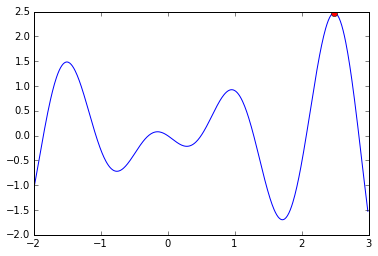

In [4]:
X = np.arange(minimo, maximo, prec)
plt.plot(X, func(X))

maximo_x = 2.48852668729269
plt.plot(maximo_x, func(maximo_x), 'or')

# Implementación del Algoritmo

Al igual que con *Hill Climbing*, si se quiere utilizar a *Simulated Annealing* como heurística de búsqueda, debemos definir estas tres cuestiones:

1. Cómo se van a representar las potenciales soluciones al problema y de que manera se podrán generar soluciones al azar.

2. Cómo calificar una soluciones potencial, para comparar dos soluciones representadas y poder determinar cual de las dos es mejor que la otra intentando resolver el problema (aunque ninguna de las dos realmente lo resuelva).

3. Cómo generar a partir de una solución dada un conjunto de nuevas soluciones vecinas a esta, lo que implica definir además una métrica de distancia entre soluciones.
 
El algoritmo puede implementarse de la siguiente forma:

In [5]:
def simulated_annealing(solucion_inicial, evaluacion, obtener_vecinos,
                        T_max, T_min, reduccion):
    """
    Simulated Annealing.
    """
    from random import random

    solucion_mejor = solucion_actual = solucion_inicial
    evaluacion_mejor = evaluacion_actual = evaluacion(solucion_actual)
    soluciones_evaluadas = 1

    T = T_max
    while T >= T_min:
        vecinos = obtener_vecinos(solucion_actual)
        for vecino in vecinos:
            evaluacion_vecino = evaluacion(vecino)
            soluciones_evaluadas += 1
            
            if (evaluacion_vecino > evaluacion_actual or
                random() < np.exp((evaluacion_vecino - evaluacion_actual) / T)):
                solucion_actual = vecino
                evaluacion_actual = evaluacion_vecino
                if evaluacion_mejor < evaluacion_actual:
                    solucion_mejor = solucion_actual
                    evaluacion_mejor = evaluacion_actual

        T = reduccion * T

    return solucion_mejor, soluciones_evaluadas

# Representación y generación de potenciales soluciones

Si a las soluciones se las representan como valores en punto flotante, puede generarse una solución al azar usando la función `random()` y escalando el valor al intervalo de trabajo, redondeando con `round()` a la cantidad de decimales que define la precisión.

In [6]:
def nueva():
    return round(minimo + random.random() * (maximo - minimo), 2)

In [7]:
print(nueva(), nueva(), nueva(), nueva(), nueva(), nueva(), sep='    ')

2.6    1.99    0.03    0.0    1.88    1.14


# Evaluación de las soluciones

Para evaluar una solución, podemos usar directamente la función que queremos maximizar ya que si la calificación de un punto será el valor de la función evaluada en ese punto, cuanto mayor sea mejor será resolviendo el problema.

In [8]:
def evaluacion(x):
    return func(x)

# Generación de soluciones vecinas

Para generar soluciones dentro de la vecindad de una solución dada, simplemente generamos 4 nuevas soluciones: $[ x-0.03, x-0.01, x+0.01, x+0.03]$. Estas cuatro soluciones tienen la particularidad que se encuentran dentro del entorno $(x \pm 0.05)$ y son valores representados con la precisión deseada.

Es importante tomar la precaución de no generar soluciones fuera del rango permitido. Por ejemplo, si $x=3$, no deberían generarse soluciones mayores que x pues se encontrarían fuera del rango fijado para el problema.

In [9]:
def vecinos(x):
    v = []
    d = -0.03
    for i in range(4):
        n = x + d
        if n >= minimo and n <= maximo:
            v.append(n)
        d += 0.02
    return v

In [10]:
print(vecinos(0.5), vecinos(1), vecinos(minimo), vecinos(maximo), sep="\n")

[0.47, 0.49, 0.51, 0.53]
[0.97, 0.99, 1.01, 1.03]
[-1.99, -1.97]
[2.97, 2.99]


# Parámetros del algoritmo

Para determinar la temperatura inicial (`T_max`) o la temperatura final (`T_min`), debemos preguntarnos:

¿Con qué probabilidad $prob$ quiero que se elijan soluciones peores que la actual en $E = eval(vecino) - eval(actual)$?

Sabiendo que $prob = e^{\frac{eval(vecino) - eval(actual)}{t}}$, obtenemos que $T = \frac{eval(vecino) - eval(actual)}{ln(prob)}$.

Así, si se quiere que inicialmente no se acepten soluciones peores que la actual en $0.5$, usando como $prob = 0.01$, se obtiene:

In [11]:
dif  = 0.5
prob = 0.01

T_max = -dif / np.log(prob)
T_max

0.10857362047581297

Graficando la curva de probabilidad de aceptración para `T_max`:

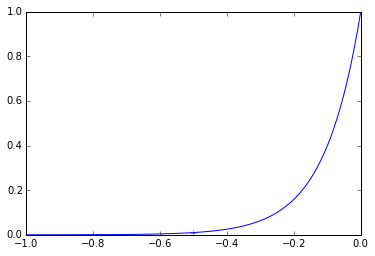

In [12]:
X = np.linspace(-2*dif, 0, 100)
plt.plot(X, np.exp(X / T_max), -dif, prob, '+r');

De la misma forma, si al final de la ejecución no se quieren soluciones peores que la actual en $0.01$, usando como $prob = 0.01$, se obtiene:

In [13]:
dif  = 0.01
prob = 0.01

T_min = -dif / np.log(prob)
T_min

0.0021714724095162593

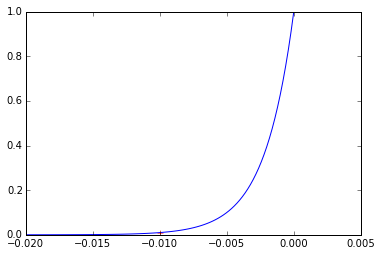

In [14]:
X = np.linspace(-2*dif, 0, 100)
plt.plot(X, np.exp(X / T_min), -dif, prob, '+r');

El factor de reducción estará asociado a la cantidad de pasos que queremos realizar para ir desde `T_max` hasta `T_min`. El algoritmo funcionará reduciendo la temperatura actual multiplicándola por el factor de reducción: $T_{(i)} = r \cdot T_{(i-1)}$

Partiendo con $T = T_{max}$ y reduciendo la temperatura de la forma indicada, $T < T_{min}$ cuando $T_{max} \cdot  r \cdot  r \cdot \, ... \, \cdot  r < T_{min}$, o sea,  $T_{max} \cdot  r ^ N < T_{min}$.

Así, para determinar el factor de reducción $r$ a partir de la cantidad de reducciones $N$ que se quiera hacer, simplemente puede calcularse:

$T_{max} \cdot  r ^ N = T_{min}
\quad \Rightarrow \quad
r ^ N = \frac{T_{min}}{T_{max}}
\quad \Rightarrow \quad
\log {r ^ N} = \log {\frac{T_{min}}{T_{max}}}
\quad \Rightarrow \quad
N \cdot \log r = \log {\frac{T_{min}}{T_{max}}}
\quad \Rightarrow \quad
\log r = \frac {\log {\frac{T_{min}}{T_{max}}}} {N}
\quad \Rightarrow \quad
r = e ^ {\left ( {\frac {\log {\frac{T_{min}}{T_{max}}}} {N}} \right ) }$

Si $N = 30$, el factor de reducción $r$ a usar sería:

In [15]:
N = 30
reduccion = np.exp(np.log(T_min / T_max) / N)
reduccion

0.8777435898906345

Podemos comprobar que eso es efectivamente así:

In [16]:
i = 0
T = T_max
while T >= T_min:
    print("Iteración", i, "- Temperatura:", T)
    T = reduccion * T
    i += 1

Iteración 0 - Temperatura: 0.108573620476
Iteración 1 - Temperatura: 0.0952997994039
Iteración 2 - Temperatura: 0.0836487880446
Iteración 3 - Temperatura: 0.0734221875083
Iteración 4 - Temperatura: 0.0644458544411
Iteración 5 - Temperatura: 0.0565669356307
Iteración 6 - Temperatura: 0.0496512651496
Iteración 7 - Temperatura: 0.043581079715
Iteración 8 - Temperatura: 0.0382530133604
Iteración 9 - Temperatura: 0.0335763372711
Iteración 10 - Temperatura: 0.0294714148117
Iteración 11 - Temperatura: 0.025868345436
Iteración 12 - Temperatura: 0.0227057743875
Iteración 13 - Temperatura: 0.0199298479221
Iteración 14 - Temperatura: 0.0174932962612
Iteración 15 - Temperatura: 0.0153546286593
Iteración 16 - Temperatura: 0.0134774268808
Iteración 17 - Temperatura: 0.0118297250529
Iteración 18 - Temperatura: 0.0103834653353
Iteración 19 - Temperatura: 0.00911402013894
Iteración 20 - Temperatura: 0.00799977275509
Iteración 21 - Temperatura: 0.00702174925636
Iteración 22 - Temperatura: 0.006163295399

# Obteniendo resultados

Finalmente, podemos invocar al algoritmo generando una solución inicial al azar y pasando la función de evaluación y la función generadora de vecinos:

In [17]:
inicial = nueva()
mejor, evaluaciones = simulated_annealing(inicial, evaluacion, vecinos,
                                          T_max=T_max, 
                                          T_min=T_min, 
                                          reduccion=reduccion)

Podemos ver el resultado de la ejecución junto con la cantidad de soluciones que tuvieron que evaluarse para conseguirla:

Cantidad de soluciones evaluadas: 125
Solución inicial: -1.95
Solución obtenida: -1.4999999999999996
Valor de func para esa solución: 1.48403736994


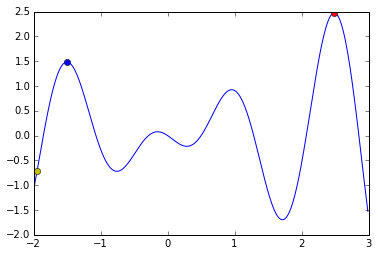

In [18]:
X = np.arange(minimo, maximo, prec)

plt.plot(X, func(X),
         maximo_x, func(maximo_x), 'or',  # Punto rojo: Máximo de la función
         inicial, func(inicial), 'oy',    # Punto amarillo: Solución inicial
         mejor, func(mejor), 'ob')        # Punto azul: Mejor solución encontrada

print("Cantidad de soluciones evaluadas:", evaluaciones)
print("Solución inicial:", inicial)
print("Solución obtenida:", mejor)
print("Valor de func para esa solución:", func(mejor))

Podemos interactuar con el algoritmo observando todas las soluciones que generó a lo largo de su ejecución. Para ello, modificamos el algoritmo para que las devuelva:

In [19]:
def simulated_annealing(solucion_inicial, evaluacion, obtener_vecinos,
                        T_max, T_min, reduccion):
    """
    Simulated Annealing.
    """
    from random import random

    soluciones = [solucion_inicial]
    solucion_mejor = solucion_actual = solucion_inicial
    evaluacion_mejor = evaluacion_actual = evaluacion(solucion_actual)
    soluciones_evaluadas = 1

    T = T_max
    while T >= T_min:
        vecinos = obtener_vecinos(solucion_actual)
        for vecino in vecinos:
            evaluacion_vecino = evaluacion(vecino)
            soluciones_evaluadas += 1
            
            if (evaluacion_vecino > evaluacion_actual or
                random() < np.exp((evaluacion_vecino - evaluacion_actual) / T)):
                solucion_actual = vecino
                evaluacion_actual = evaluacion_vecino
                soluciones.append(vecino)
                if evaluacion_mejor < evaluacion_actual:
                    solucion_mejor = solucion_actual
                    evaluacion_mejor = evaluacion_actual

        T = reduccion * T

    return solucion_mejor, soluciones_evaluadas, soluciones

In [20]:
from IPython.html.widgets import interact, IntSliderWidget

/Users/raulparola/anaconda/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


ImportError: No module named 'widgets'

El siguiente código ejecuta el algorimo modificado y grafica en forma interactiva cada una de las soluciones elegidas (en color verde) comenzando a partir de la solución inicial (color amarillo). También indica el máximo de la función (color rojo) y la mejor solución encontrada durante la ejecución (color azul):

In [21]:
# Usando una solución inicial fija, puede verse como cambia el comportamiento del algoritmo.
inicial = 1.6

mejor, evaluaciones, soluciones = simulated_annealing(inicial, evaluacion, vecinos,
                                          T_max=T_max, T_min=T_min, reduccion=reduccion)

X = np.arange(minimo, maximo, prec)
puntos = np.array(soluciones)

def p(t):
    plt.plot(X, func(X),
         maximo_x, func(maximo_x), 'or',    # Punto rojo: Máximo de la función
         inicial, func(inicial), 'oy',      # Punto amarillo: Solución inicial
         puntos[t], func(puntos[t]), 'og',  # Punto verde: Solución intermedia
         mejor, func(mejor), 'ob')          # Punto azul: Mejor solución hallada
    plt.show()
    
i = interact(p, t=IntSliderWidget(min=0, max=len(soluciones)-1, step=1, value=0))

print("Cantidad de soluciones evaluadas:", evaluaciones)

NameError: name 'interact' is not defined